# Gaussian Mixture Model(GMM)

In [1]:
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt
from numpy import unique, where
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd

import seaborn as sns
import numpy as np
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import adjusted_rand_score, silhouette_score, davies_bouldin_score
from sklearn import preprocessing 
import plotly.express as px
import time

In [3]:
datasets = {
    "Spherical Clusters": pd.read_csv('./Datasets/Speherical_Clusters.csv'),
    "Moon Clusters": pd.read_csv('./Datasets/moons_Clusters.csv'),
    "Nested Clusters": pd.read_csv('./Datasets/Nested_Clusters.csv'),
    "Hierarchical Structure": pd.read_csv('./Datasets/Mall_Customers.csv')
    
}
label_encoder = preprocessing.LabelEncoder() 

#encode gender
datasets['Hierarchical Structure']['Gender'] = label_encoder.fit_transform(datasets['Hierarchical Structure']['Gender'])

In [191]:
print("Spherical Clusters Dataset:")
print(datasets["Spherical Clusters"].head())

print("\nMoon Clusters Dataset:")
print(datasets["Moon Clusters"].head())

print("\nNested Clusters Dataset:")
print(datasets["Nested Clusters"].head())

print("\nHierarchical Structure Dataset:")
print(datasets["Hierarchical Structure"].head())

Spherical Clusters Dataset:
   Feature1  Feature2  Cluster
0 -2.004128  7.852632        3
1  0.670479  4.040943        0
2 -2.263678  8.273068        3
3 -2.350730  2.277237        2
4  2.228740  1.145386        1

Moon Clusters Dataset:
   Feature1  Feature2  Cluster
0  2.064430  0.546069        1
1  1.762473 -0.062689        1
2 -0.245490  0.668868        0
3 -0.174630  0.183882        1
4  0.452110 -0.406512        1

Nested Clusters Dataset:
   Feature1  Feature2  Cluster
0 -0.163255 -0.086455        0
1 -0.011146  0.011499        0
2 -2.115056  1.405365        2
3  0.542611  0.715939        1
4  2.320800  0.117091        2

Hierarchical Structure Dataset:
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1       1   19                  15                      39
1           2       1   21                  15                      81
2           3       0   20                  16                       6
3           4       0   23                  16 

In [4]:
scaler = StandardScaler()
encoder = OneHotEncoder(drop="if_binary", sparse_output=False)


def preprocess(
    dataset_name, return_original=False, return_scaler=False, return_encoder=False
):
    data = datasets[dataset_name]
    if dataset_name == "Hierarchical Structure":
        enc_gender = encoder.fit_transform(data[["Gender"]])
        scaled_numerical = scaler.fit_transform(
            data[["Age", "Annual Income (k$)", "Spending Score (1-100)"]]
        )
        X = np.hstack((enc_gender, scaled_numerical))
        y = None
    elif dataset_name == "Hierarchical Structure (Zoo)":
        X = data[["hair", "predator", "legs"]].to_numpy()
        y = data["class_type"].to_numpy()
    else:
        data = data.to_numpy()
        X = scaler.fit_transform(data[:, :-1])
        y = data[:, -1]

    result = [X, y]
    if return_original:
        result.append(data)
    # if return_scaler:
    #     result.append(scaler)
    # if return_encoder:
    #     result.append(encoder)

    return tuple(result)

In [5]:
def run_GMM(X, params):
    """
    Fit a Gaussian Mixture Model (GMM) to the data and return the predictions and model.

    Args:
        X (np.ndarray): Input feature matrix.
        params (dict): Parameters for the GMM.

    Returns:
        tuple: Predicted labels, fitted GMM model, and elapsed time.
    """
    start_time = time.time()
    gmm = GaussianMixture(**params).fit(X)
    t_elapsed = time.time() - start_time
    return gmm.predict(X), gmm, t_elapsed

In [6]:
class Metrics:
    """This class stores all the metrics after running grid search for a single algorithm in a DataFrame."""

    metrics_used = ["bic", "silhouette", "ari", "davies-bouldin"]

    def __init__(self, adjustable_params: list, X, y) -> None:
        df_cols = adjustable_params + [key for key in self.metrics_used]
        self.table = pd.DataFrame(columns=df_cols)
        self.X = X
        self.y = y
        self.best_models = {metric: None for metric in self.metrics_used}
        self.best_scores = {
            "bic": float("inf"),
            "silhouette": float("-inf"),
            "ari": float("-inf"),
            "davies-bouldin": float("inf"),
            "train_time": float("inf")
        }

    @staticmethod
    def get_score(metric: str, X, y_true, y_pred):
        if metric == "silhouette" and len(set(y_pred)) > 1:
            return silhouette_score(X=X, labels=y_pred)
        elif metric == "ari" and y_true is not None:
            return adjusted_rand_score(labels_true=y_true, labels_pred=y_pred)
        elif metric == "davies-bouldin" and len(set(y_pred)) > 1:
            return davies_bouldin_score(X=X, labels=y_pred)
        return None

    def add(self, params: dict, bic, train_time, pred, model):
        new_row = {**params, "bic": bic, "train_time": train_time}
        for metric in self.metrics_used:
            if metric not in ["bic", "train_time"]:
                score = self.get_score(metric, self.X, self.y, pred)
                new_row.update({metric: score})
        self.table.loc[len(self.table.index)] = new_row

        # Update the best models for each metric
        for metric in self.metrics_used:
            score = new_row[metric]
            if score is not None:
                if metric in ["bic", "davies-bouldin", "train_time"]:
                    if score < self.best_scores[metric]:
                        self.best_scores[metric] = score
                        self.best_models[metric] = model
                else:
                    if score > self.best_scores[metric]:
                        self.best_scores[metric] = score
                        self.best_models[metric] = model

    def get_best(self, evaluated_metric: str):
        if evaluated_metric in ["bic", "davies-bouldin", "train_time"]:
            min_idx = self.table[evaluated_metric].idxmin()
            return self.table.iloc[min_idx]
        else:
            max_idx = self.table[evaluated_metric].idxmax()
            return self.table.iloc[max_idx]

    def get_df(self):
        return self.table

    def get_best_params(self, evaluated_metric: str):
        """Find the best parameter combination based on the evaluated metric."""
        best_row = self.get_best(evaluated_metric)
        best_params = best_row.drop(self.metrics_used).to_dict()
        return best_params

    def get_best_model(self, evaluated_metric: str):
        """Return the best model found during the grid search based on the evaluated metric."""
        return self.best_models[evaluated_metric]

In [7]:
def run_grid(test_params, param_grid, X, y):
    """Runs grid search without cross validation folds and returns the best parameters and model for each metric.

    Args:
        test_params (dict): Parameters to test.
        param_grid (list): List of parameter combinations.
        X (np.ndarray): Input feature matrix.
        y (np.ndarray): Ground truth labels.

    Returns:
        dict: Best parameter combinations for each metric.
        dict: Best models for each metric.
        pd.DataFrame: DataFrame of metrics.
    """

    metrics = Metrics(
        adjustable_params=[key for key in test_params],
        X=X,
        y=y,
    )

    for params in param_grid:
        pred, model, t_elapsed = run_GMM(X, params)
        bic = model.bic(X)
        metrics.add(params, bic, t_elapsed, pred, model)

    best_params = {metric: metrics.get_best_params(metric) for metric in metrics.metrics_used}
    best_models = {metric: metrics.get_best_model(metric) for metric in metrics.metrics_used}
    return best_params, best_models, metrics.get_df()

In [8]:
params = {
    'n_components': [2, 3, 4],
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],
    'random_state': [0],
    'max_iter': [100, 200, 300],  # Increased max_iter
    'init_params': ['kmeans','random_from_data','k-means++', 'random'],  # Different initialization methods
    'tol': [1e-3, 1e-4]  # Adjust tolerance
}
GMM_params_combinations = ParameterGrid(params)

In [11]:
def plot_gmm_results(X, gmm_result, title):
    gmm_clusters = unique(gmm_result)
    for gmm_cluster in gmm_clusters:
        # Get data points that fall in this cluster
        index = where(gmm_result == gmm_cluster)
        # Make the plot
        plt.scatter(X[index, 0], X[index, 1], label=f'Cluster {gmm_cluster}')
    plt.title(title)
    plt.legend()
    plt.show()

In [9]:
def plot_metrics(GMM_grid, dataset_name):
    plt.figure(figsize=(15, 10))

    # Plot BIC vs. Number of Components
    plt.subplot(2, 2, 1)
    sns.lineplot(data=GMM_grid, x='n_components', y='bic', hue='covariance_type', marker='o')
    plt.title(f'BIC vs. Number of Components ({dataset_name})')
    plt.xlabel('Number of Components')
    plt.ylabel('BIC')
    plt.legend(title='Covariance Type')

    # Plot Silhouette Score vs. Number of Components
    plt.subplot(2, 2, 2)
    sns.lineplot(data=GMM_grid, x='n_components', y='silhouette', hue='covariance_type', marker='o')
    plt.title(f'Silhouette Score vs. Number of Components ({dataset_name})')
    plt.xlabel('Number of Components')
    plt.ylabel('Silhouette Score')
    plt.legend(title='Covariance Type')

    # Plot ARI vs. Number of Components
    plt.subplot(2, 2, 3)
    sns.lineplot(data=GMM_grid, x='n_components', y='ari', hue='covariance_type', marker='o')
    plt.title(f'ARI vs. Number of Components ({dataset_name})')
    plt.xlabel('Number of Components')
    plt.ylabel('ARI')
    plt.legend(title='Covariance Type')

    # Plot Davies-Bouldin Score vs. Number of Components
    plt.subplot(2, 2, 4)
    sns.lineplot(data=GMM_grid, x='n_components', y='davies-bouldin', hue='covariance_type', marker='o')
    plt.title(f'Davies-Bouldin Score vs. Number of Components ({dataset_name})')
    plt.xlabel('Number of Components')
    plt.ylabel('Davies-Bouldin Score')
    plt.legend(title='Covariance Type')

    plt.tight_layout()
    plt.show()

Best parameters for Spherical Clusters:
  bic: {'n_components': 4, 'covariance_type': 'tied', 'random_state': 0, 'max_iter': 100, 'init_params': 'kmeans', 'tol': 0.0001}
  silhouette: {'n_components': 4, 'covariance_type': 'spherical', 'random_state': 0, 'max_iter': 100, 'init_params': 'kmeans', 'tol': 0.001}
  ari: {'n_components': 4, 'covariance_type': 'tied', 'random_state': 0, 'max_iter': 100, 'init_params': 'kmeans', 'tol': 0.001}
  davies-bouldin: {'n_components': 4, 'covariance_type': 'full', 'random_state': 0, 'max_iter': 100, 'init_params': 'k-means++', 'tol': 0.001}


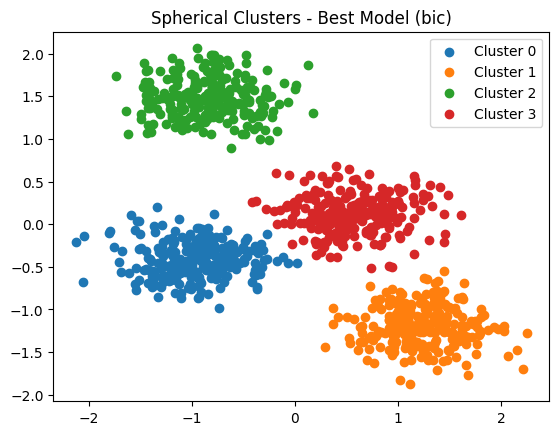

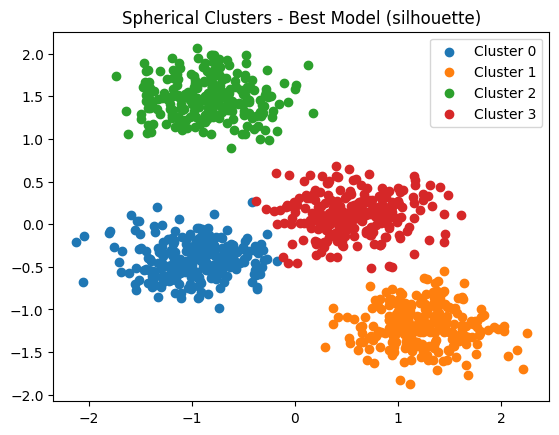

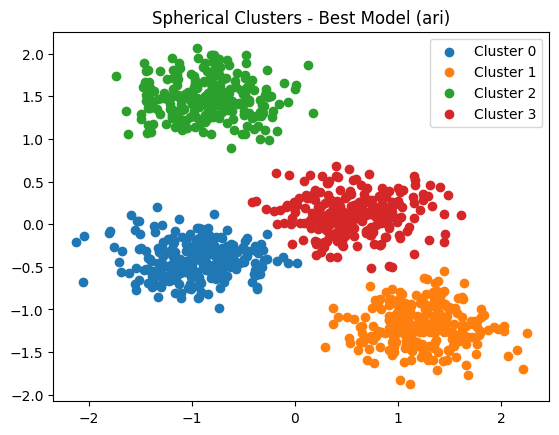

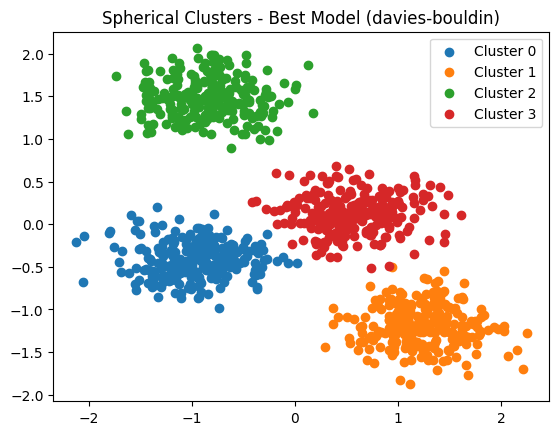

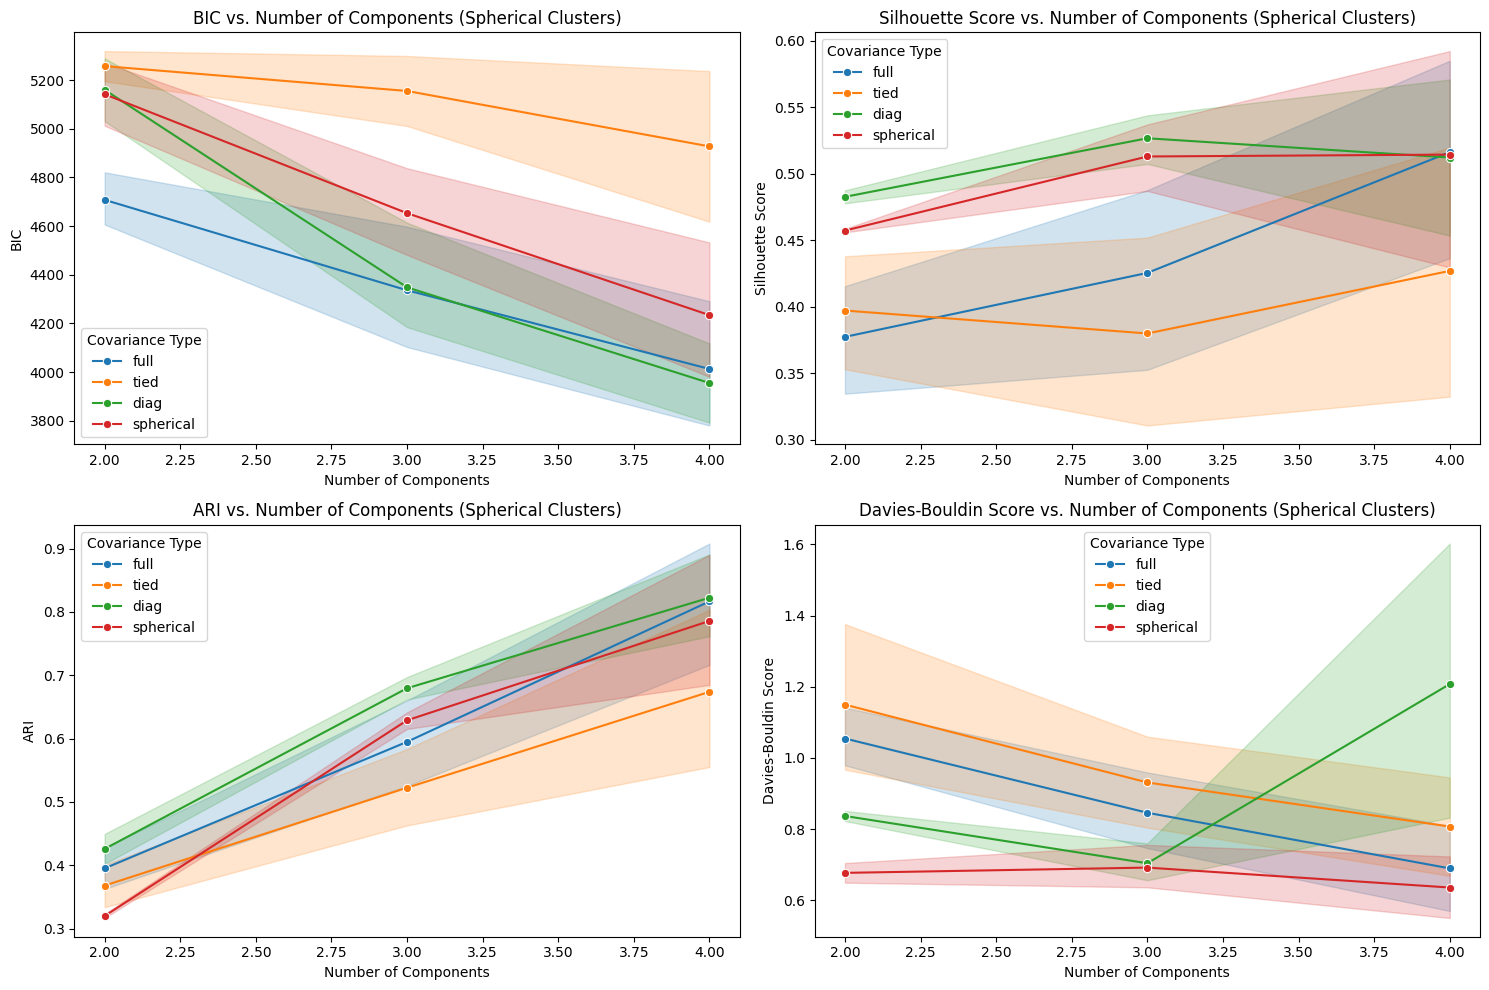

c:\Users\liang\Downloads\Env\myenv\lib\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Best parameters for Moon Clusters:
  bic: {'n_components': 4, 'covariance_type': 'full', 'random_state': 0, 'max_iter': 100, 'init_params': 'k-means++', 'tol': 0.0001}
  silhouette: {'n_components': 2, 'covariance_type': 'diag', 'random_state': 0, 'max_iter': 100, 'init_params': 'kmeans', 'tol': 0.001}
  ari: {'n_components': 2, 'covariance_type': 'tied', 'random_state': 0, 'max_iter': 100, 'init_params': 'random', 'tol': 0.001}
  davies-bouldin: {'n_components': 4, 'covariance_type': 'spherical', 'random_state': 0, 'max_iter': 100, 'init_params': 'kmeans', 'tol': 0.0001}


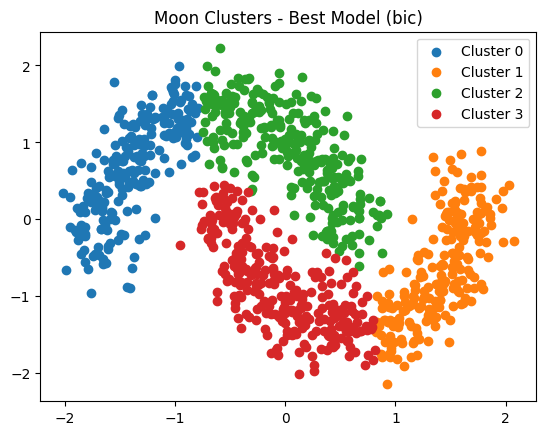

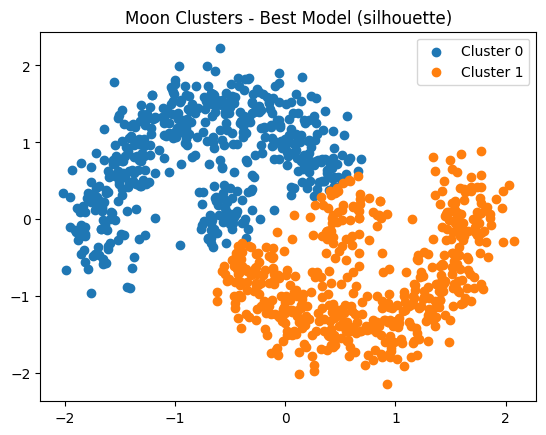

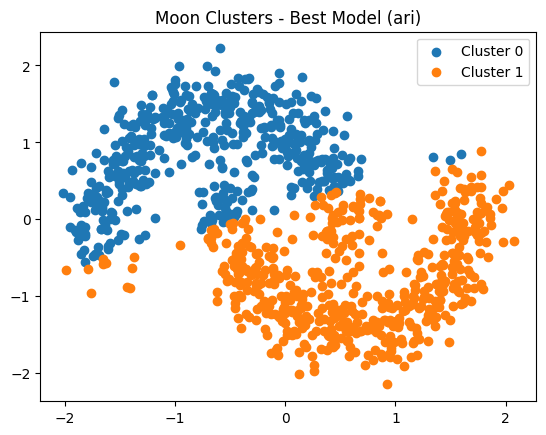

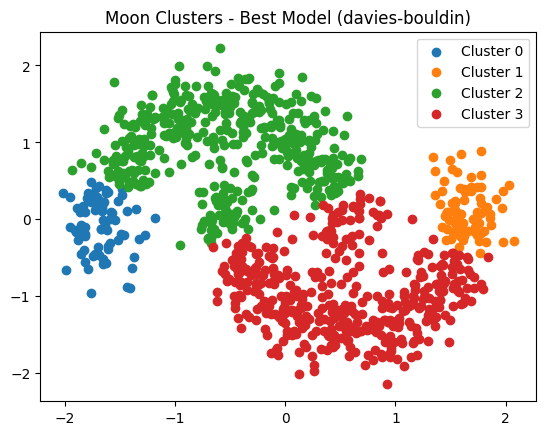

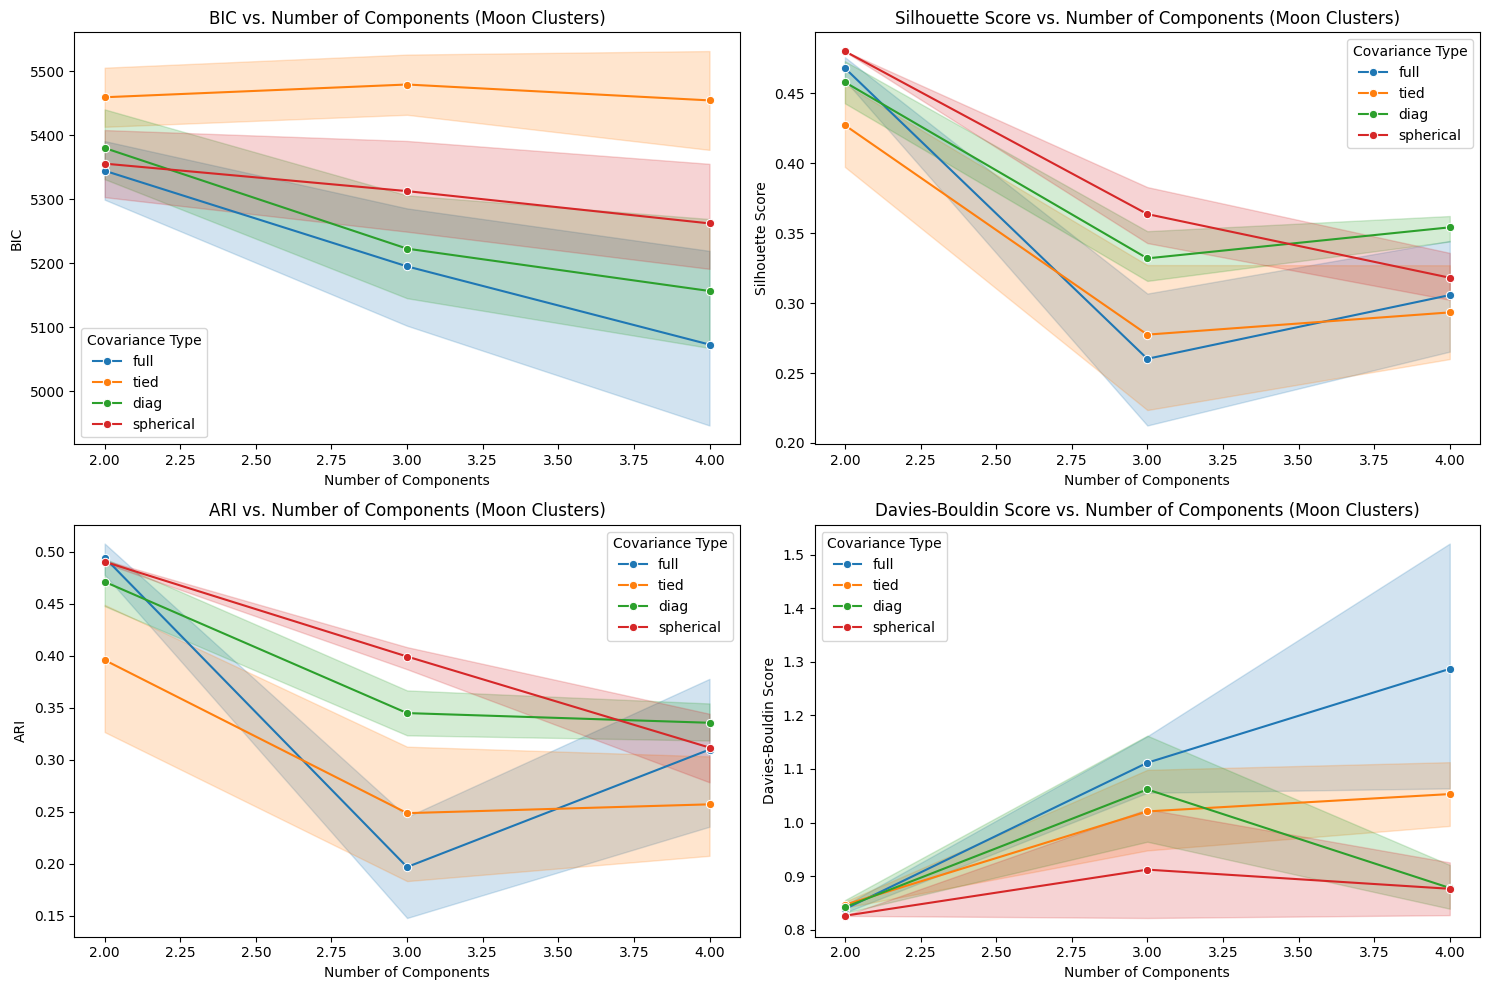

C:\Users\liang\AppData\Local\Temp\ipykernel_33484\1602082827.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.table.loc[len(self.table.index)] = new_row
C:\Users\liang\AppData\Local\Temp\ipykernel_33484\1602082827.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.table.loc[len(self.table.index)] = new_row
C:\Users\liang\AppData\Local\Temp\ipykernel_33484\1602082827.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a futu

Best parameters for Nested Clusters:
  bic: {'n_components': 2, 'covariance_type': 'spherical', 'random_state': 0, 'max_iter': 100, 'init_params': 'random', 'tol': 0.001}
  silhouette: {'n_components': 4, 'covariance_type': 'diag', 'random_state': 0, 'max_iter': 100, 'init_params': 'random', 'tol': 0.001}
  ari: {'n_components': 4, 'covariance_type': 'diag', 'random_state': 0, 'max_iter': 100, 'init_params': 'random_from_data', 'tol': 0.001}
  davies-bouldin: {'n_components': 4, 'covariance_type': 'diag', 'random_state': 0, 'max_iter': 100, 'init_params': 'random', 'tol': 0.001}


C:\Users\liang\AppData\Local\Temp\ipykernel_33484\1602082827.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.table.loc[len(self.table.index)] = new_row
C:\Users\liang\AppData\Local\Temp\ipykernel_33484\1602082827.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.table.loc[len(self.table.index)] = new_row


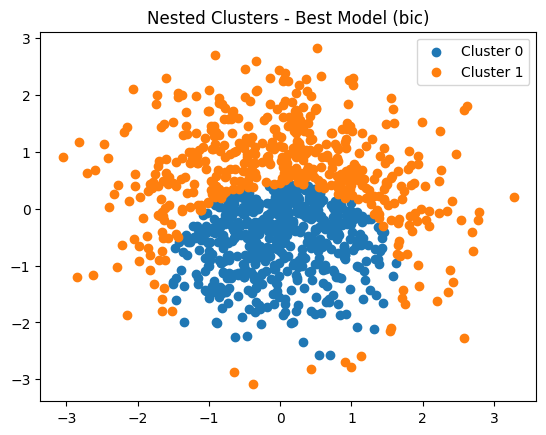

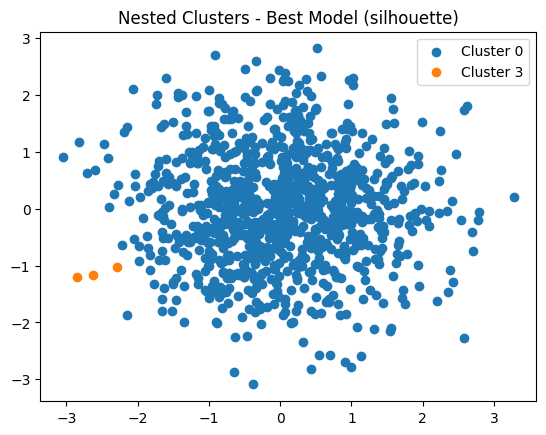

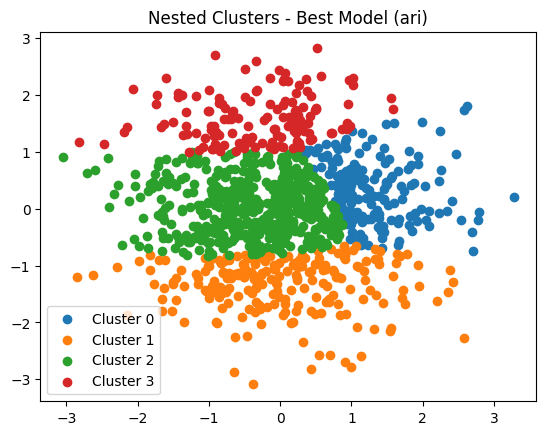

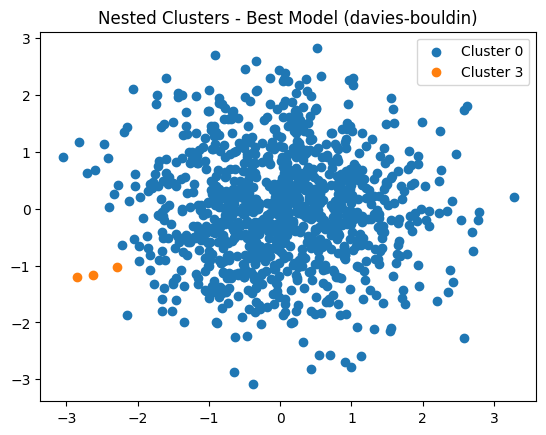

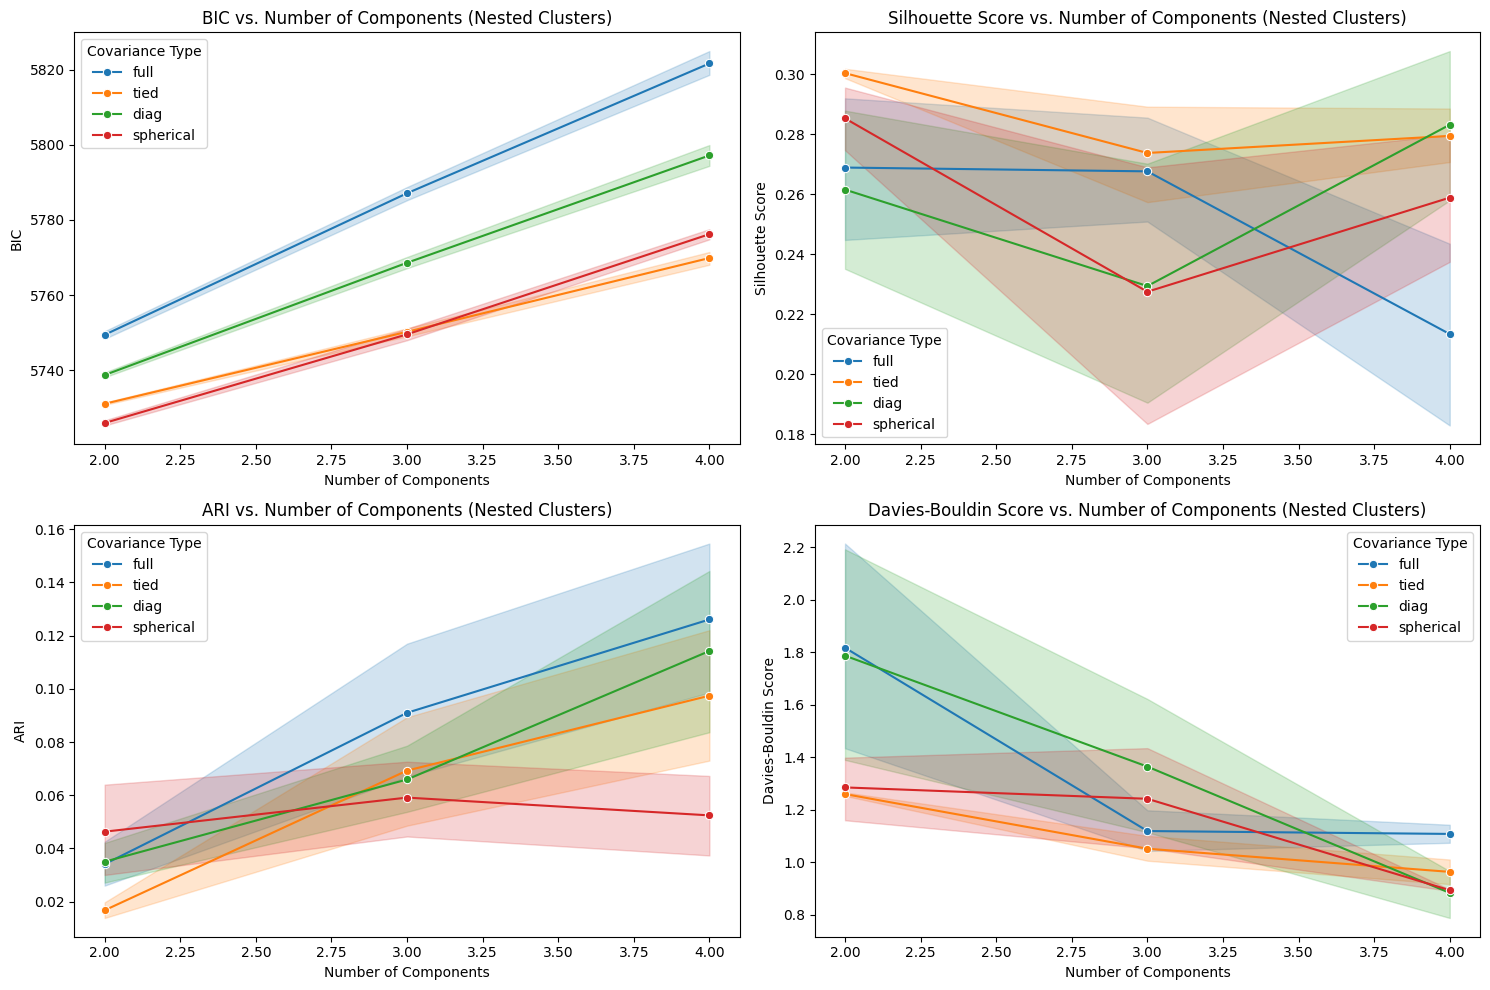

In [13]:
for dataset_name in datasets.keys():
    X, y = preprocess(dataset_name)
    best_params, best_models, GMM_grid = run_grid(test_params=params, param_grid=GMM_params_combinations, X=X, y=y)
    print(f"Best parameters for {dataset_name}:")
    for metric in best_params:
        print(f"  {metric}: {best_params[metric]}")

    # Predict using the best models and plot results
    for metric in best_models:
        best_model = best_models[metric]
        if best_model is not None:
            best_model_labels = best_model.predict(X)
            if dataset_name == "Hierarchical Structure":
                # Special handling for 4-dimensional data
                data = datasets[dataset_name]
                data['GMM_Cluster'] = best_model_labels
                fig = px.scatter_3d(data, x='Age', y='Annual Income (k$)', z='Spending Score (1-100)', color='GMM_Cluster',
                                    title=f"3D GMM Clustering on {dataset_name} Dataset", labels={'GMM_Cluster': 'Cluster'})
                fig.update_traces(marker=dict(size=3))
                fig.show()
            else:
                plot_gmm_results(X, best_model_labels, f"{dataset_name} - Best Model ({metric})")

    # Plot the evaluation metrics
    plot_metrics(GMM_grid, dataset_name)

#### GMM on Spherical Clusters

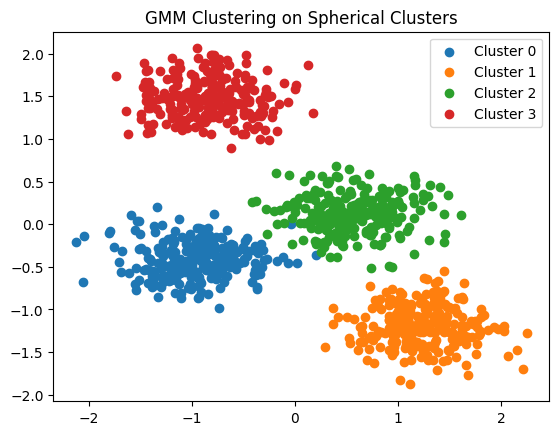

Adjusted Rand Index: 1.0000
Silhouette Score: 0.7252


In [18]:
scaler = StandardScaler()
data = datasets["Spherical Clusters"] 
data = scaler.fit_transform(data)

# Define the GMM model
gmm_model = GaussianMixture(n_components=4, random_state=0)  

# Fit and predict the clusters
gmm_result = gmm_model.fit_predict(data)

# Plot the results
plot_gmm_results(data, gmm_result, title=f"GMM Clustering on Spherical Clusters")
evaluate_gmm(true_labels_spherical, gmm_result, data)

#### GMM on Moon Clusters

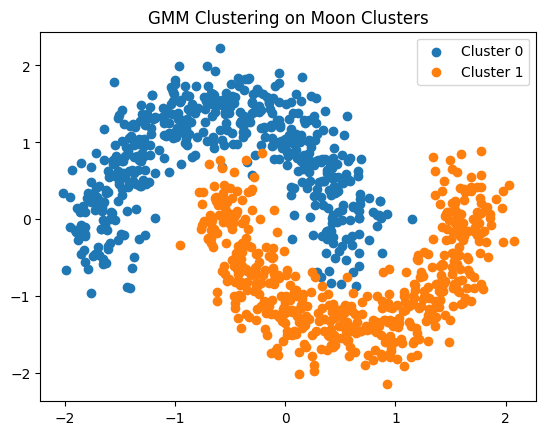

Adjusted Rand Index: 1.0000
Silhouette Score: 0.5577


In [19]:
scaler = StandardScaler()
data = datasets["Moon Clusters"] 
data = scaler.fit_transform(data)

# Define the GMM model
gmm_model = GaussianMixture(n_components=2, random_state=0)  

# Fit and predict the clusters
gmm_result = gmm_model.fit_predict(data)

# Plot the results
plot_gmm_results(data, gmm_result, title=f"GMM Clustering on Moon Clusters")
evaluate_gmm(true_labels_moon, gmm_result, data)    

#### GMM on Nested Clusters

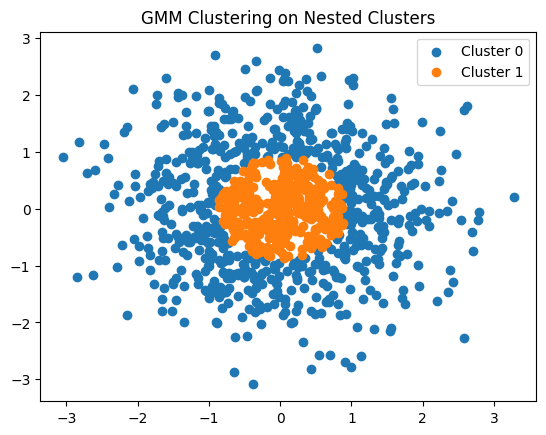

Adjusted Rand Index: 0.5706
Silhouette Score: 0.2542


In [20]:
scaler = StandardScaler()
data = datasets["Nested Clusters"] 
data = scaler.fit_transform(data)

# Define the GMM model
gmm_model = GaussianMixture(n_components=2, random_state=0)  

# Fit and predict the clusters
gmm_result = gmm_model.fit_predict(data)

# Plot the results
plot_gmm_results(data, gmm_result, title=f"GMM Clustering on Nested Clusters")
evaluate_gmm(true_labels_nested, gmm_result, data)

#### GMM on Hierarchical Clusters

In [21]:
# Load the dataset
data = datasets["Hierarchical Structure"]


# Select the feature columns
feature_columns = ['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']

# Scale the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[feature_columns])

# Define the GMM model
gmm_model = GaussianMixture(n_components=10, random_state=0)

# Fit and predict the clusters
gmm_result = gmm_model.fit_predict(data_scaled)

# Add GMM result to the original dataset
data['GMM_Cluster'] = gmm_result

# Plot the 3D scatter plot
fig = px.scatter_3d(data, x='Age', y='Annual Income (k$)', z='Spending Score (1-100)', color='GMM_Cluster',
                    title="3D GMM Clustering on Mall Customers Dataset", labels={'GMM_Cluster': 'Cluster'})
fig.update_traces(marker=dict(size=3)) 

fig.show()

In [22]:

# Calculate and print the Silhouette Score
silhouette_avg = silhouette_score(data, gmm_result)
print(f"Silhouette Score: {silhouette_avg:.4f}")

Silhouette Score: -0.0272
